In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import argparse
from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.fftpack import  fft, ifft, ifftshift
from scipy.signal import correlate
from sklearn.metrics import r2_score
import sys

sys.path.append('..')

from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

In [3]:
# session_list = [
#     'MrJones-Anesthesia-20160113-01',
#     'Mary-Anesthesia-20160809-01',
#     'MrJones-Anesthesia-20160105-01',
#     'Mary-Anesthesia-20160818-02',
#     'MrJones-Anesthesia-20160121-01',
#     'Mary-Anesthesia-20160831-02',
#     'MrJones-Anesthesia-20160123-01'
# ]

# session_list = [
#     'Mary-Anesthesia-20160902-02',
#     'Mary-Anesthesia-20160908-02',
#     'Mary-Anesthesia-20160914-02',
#     'Mary-Anesthesia-20160916-02',

#     'MrJones-Anesthesia-20160125-01',
#     'MrJones-Anesthesia-20160201-01',
#     'MrJones-Anesthesia-20160206-01',
#     'MrJones-Anesthesia-20160210-01',
#     'MrJones-Anesthesia-20160301-01'
# ]

session_list = os.listdir("/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results")

In [4]:
session_list = session_list[:2]
# session_list = session_list[4:]

In [5]:
area = 'all'

In [6]:
session = 'MrJones-Anesthesia-20160301-01'

# -----------------------------------------
# LOAD DATA AND DIRECTORY
# -----------------------------------------
print("loading data...")
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
#     areas = np.unique(electrode_info['area'])
# areas = np.hstack([areas, 'all'])
areas = ['all']

print("data loaded!")
print("loading directory")

chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

print("directory loaded!")


area = 'all'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

norm_folder = "NOT_NORMED"

# -----------------------------------------
# LOAD GRID SEARCH RESULTS
# -----------------------------------------

session_results = {}
session_results[session] = {}
# data_processing_df_grid = deepcopy(mp_args.data_processing_df)

grid_results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'
areas = os.listdir(os.path.join(grid_results_dir, session, norm_folder))

for area in areas:
    df = pd.DataFrame({'window': [], 'matrix_size': [], 'r': [], 'AICs': [], 'time_vals': [], 'file_paths': []}).set_index(['window', 'matrix_size', 'r'])
    for f in os.listdir(os.path.join(grid_results_dir, session, norm_folder, area)):
        t = float(f.split('_')[0])
        file_path = os.path.join(grid_results_dir, session, norm_folder, area, f)
        df_new = pd.DataFrame(pd.read_pickle(file_path))
        if np.isnan(df_new.AIC).sum() > 0:
            print(file_path)
        df_new = df_new.set_index(['window', 'matrix_size', 'r'])
        for i, row in df_new.iterrows():
            if i in df.index:
                df.loc[i, 'AICs'].append(row.AIC)
                df.loc[i, 'time_vals'].append(t)
                df.loc[i, 'file_paths'].append(file_path)
            else:
                df.loc[i] = {'AICs': [row.AIC], 'time_vals': [t], 'file_paths': [file_path]}

    df = df.loc[df.index.sortlevel()[0]]
    session_results[session][area] = df

print("Grid search results loaded!")

# ================
# INDIVIDUAL AREAS
# ================ 
window_ind, matrix_size_ind, r_ind, all_results_ind = combine_grid_results({key: result for key, result in session_results[session].items() if key !='all'})

# ================
# ALL AREAS
# ================ 
if 'all' in session_results[session].keys():
    window_all, matrix_size_all, r_all, all_results_all = combine_grid_results({key: result for key, result in session_results[session].items() if key =='all'})

if area == 'all':
    window, matrix_size, r = window_all, matrix_size_all, r_all
else:
    window, matrix_size, r = window_ind, matrix_size_ind, r_ind

loading data...
data loaded!
loading directory
directory loaded!
Grid search results loaded!


# Compute

In [7]:
def get_fft(x, dt=1, min_freq=0, max_freq=500, spectrum_smoothing_width=0, log=False, standardize=False):
    fft = np.zeros((x.shape[1], int(x.shape[0]/2) + 1))
    for i in range(x.shape[1]):
        stdev = x[:, i].std()
        if standardize and stdev != 0:
            inp = (x[:, i] - x[:,i].mean())/stdev
        else:
            inp = x[:, i]
        fft[i] = np.abs(np.fft.rfft(inp))
    freqs = np.fft.rfftfreq(x.shape[0], d=dt)
    
    freq_inds = np.logical_and(freqs >= min_freq, freqs <= max_freq)
    fft = fft[:, freq_inds]
    freqs = freqs[freq_inds]
    
    df = freqs[0]
    if spectrum_smoothing_width > 0:
        for i in range(fft.shape[0]):
            fft[i] = scipy.ndimage.gaussian_filter1d(fft[i], spectrum_smoothing_width/df)
    
    if log:
        fft = 10*np.log10(fft)
    
    if standardize:
        for i in range(fft.shape[0]):
            fft[i] = (fft[i] - fft[i].mean())/fft.std()
    
    return fft

In [8]:
fft_kwargs = dict(
    dt=dt,
    min_freq=0.2,
    max_freq=100,
    spectrum_smoothing_width=0.5,
    log=False,
    standardize=False
)

In [9]:
def autocorrelation(x):
    ac = np.zeros((x.shape[1], int(x.shape[0]/2)))
    for i in range(ac.shape[0]):
        stdev = np.std(x[:,i])
        if stdev == 0:
            inp = x[:, i]
        else:
            inp = (x[:,i] - np.average(x[:,i]))/stdev
        xp = ifftshift(inp)
        n, = xp.shape
        xp = np.r_[xp[:n//2], np.zeros_like(xp), xp[n//2:]]
        f = fft(xp)
        p = np.absolute(f)**2
        pi = ifft(p)
        ac[i] = np.real(pi)[:n//2]/(np.arange(n//2)[::-1]+n//2)
    return ac

In [10]:
def correlation_matrices(x, num_lags=0, lag_spacing=1):
    corrmats = np.zeros((num_lags + 1, x.shape[1], x.shape[1]))
    corrmats[0] = np.corrcoef(x.T)
    for lag in range(1, num_lags + 1):
        out = np.corrcoef(x[:-lag*lag_spacing, :].T, x[lag*lag_spacing:, :].T)
        corrmats[lag] = out[:x.shape[1], x.shape[1]:]
    
    return corrmats

In [11]:
stride = 240000
# num_windows = int(len(lfp_schema['index'][0])/stride)
num_windows = int((session_info['drugEnd'][1]/dt + stride)/stride)
# time_vals = [i*stride for i in range(num_windows)]

In [61]:
models = ['true', 'PB', 'havok', 'havok_big', 'VAR', 'VAR_small']

In [62]:
all_rets = []
# metrics = ['correl', 'mse', 'autocorrel_mse', 'autocorrel_correl', 'fft_correl', 'div', 'correl_mat_correl', 'correl_mat_mse']

num_lags=5000
num_cmat_lags = 25
lag_spacing = 10
# reseeds=[500]
reseeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 50, 100, 200]

# for i in tqdm(range(num_windows)):
#     t = i*stride
time_vals = [int(500/dt), int((session_info['drugStart'][1] - 30)/dt)]
# reseeds = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp/all_reseed_results"
os.makedirs(save_dir, exist_ok=True)

iterator = tqdm(total=len(time_vals)*len(reseeds)*len(models))
for t in time_vals:
    results = {}
    
    signal_train = load_window_from_chunks(t*dt, t*dt + window*dt, directory, unit_indices)
    
    if 'havok_big' in models:
        print("fitting delase big!")
        delase_big = DeLASE(signal_train, matrix_size=6500, use_torch=True, device='cuda')
        delase_big.compute_havok_dmd(r=6000)
        print("completed delase big!")

    if 'havok' in models:
        print("fitting delase small!")
        delase_small = DeLASE(signal_train, matrix_size=matrix_size, use_torch=True, device='cuda')
        delase_small.compute_havok_dmd(r=r)
        print("completed delase small!")

    if 'VAR_small' in models:
        print("fitting VAR small!")
        small_window = 500
        A_VAR_small = np.linalg.lstsq(signal_train[:small_window-1], signal_train[1:small_window], rcond=1e-20)[0].T
        print("completed VAR small!")

    if 'VAR' in models:
        print("fitting VAR big!")
        A_VAR = np.linalg.lstsq(signal_train[:-1], signal_train[1:], rcond=1e-20)[0].T
        print("completed VAR big!")
   
    for reseed in reseeds:
        results[reseed] = {}
#         metric_kwargs['num_lags'] = np.min([num_lags, int(reseed/2)])
    #     signal_test = signal[:reseed]
#         signal_test = load_window_from_chunks(t*dt + window*dt, t*dt + 2*window*dt, directory, unit_indices)
        signal_test = load_window_from_chunks(t*dt + window*dt, t*dt + window*dt + 5000*dt, directory, unit_indices)
#         signal_test = load_window_from_chunks(t*dt + window*dt, t*dt + window*dt + reseed*dt, directory, unit_indices)
        
        if 'true' in models:
            results[reseed]['true'] = {}
            results[reseed]['true']['signal'] = signal_test
            results[reseed]['true']['autocorrel'] = autocorrelation(signal_test)[:, :num_lags]
            results[reseed]['true']['fft'] = get_fft(signal_test, **fft_kwargs)
            results[reseed]['true']['correl_mats'] = correlation_matrices(signal_test, num_cmat_lags, lag_spacing)
            iterator.update()
        
        if 'PB' in models:
            pred = np.zeros(signal_test.shape)
            pred[0] = signal_test[0]
            for t_ in range(1, signal_test.shape[0]):
                if t_ % reseed == 0:
                    pred[t_] = signal_test[t_ - 1]
                else:
                    pred[t_] = pred[t_ - 1]
            results[reseed]['PB'] = {}
            results[reseed]['PB']['signal'] = pred
            results[reseed]['PB']['autocorrel'] = autocorrelation(pred)[:, :num_lags]
            results[reseed]['PB']['fft'] = get_fft(pred, **fft_kwargs)
            results[reseed]['PB']['correl_mats'] = correlation_matrices(pred, num_cmat_lags, lag_spacing)
    #         all_metric_vals_pb.append(signal_metrics(signal_test, pred, **metric_kwargs))
            iterator.update()

        if 'havok' in models:
            pred = delase_small.predict_havok_dmd(signal_test, reseed=reseed, tail_bite=True).cpu().numpy()
            results[reseed]['havok'] = {}
            results[reseed]['havok']['signal'] = pred
            results[reseed]['havok']['autocorrel'] = autocorrelation(pred)[:, :num_lags]
            results[reseed]['havok']['fft'] = get_fft(pred, **fft_kwargs)
            results[reseed]['havok']['correl_mats'] = correlation_matrices(pred, num_cmat_lags, lag_spacing)

            iterator.update()
        if 'havok_big' in models:
            pred = delase_big.predict_havok_dmd(signal_test, reseed=reseed, tail_bite=True).cpu().numpy()
            results[reseed]['havok_big'] = {}
            results[reseed]['havok_big']['signal'] = pred
            results[reseed]['havok_big']['autocorrel'] = autocorrelation(pred)[:, :num_lags]
            results[reseed]['havok_big']['fft'] = get_fft(pred, **fft_kwargs)
            results[reseed]['havok_big']['correl_mats'] = correlation_matrices(pred, num_cmat_lags, lag_spacing)

            iterator.update()

        if 'VAR' in models:
            pred = np.zeros(signal_test.shape)
            pred[0] = signal_test[0]
            for t_ in range(1, signal_test.shape[0]):
                if t_ % reseed == 0:
                    pred[t_] = A_VAR @ signal_test[t_ - 1]
                else:
                    pred[t_] = A_VAR @ pred[t_ - 1]
    #         all_metric_vals_VAR.append(signal_metrics(signVARal_test, pred, **metric_kwargs))
            results[reseed]['VAR'] = {}
            results[reseed]['VAR']['signal'] = pred
            results[reseed]['VAR']['autocorrel'] = autocorrelation(pred)[:, :num_lags]
            results[reseed]['VAR']['fft'] = get_fft(pred, **fft_kwargs)
            results[reseed]['VAR']['correl_mats'] = correlation_matrices(pred, num_cmat_lags, lag_spacing)

            iterator.update()
        
        if 'VAR_small' in models:
            pred = np.zeros(signal_test.shape)
            pred[0] = signal_test[0]
            for t_ in range(1, signal_test.shape[0]):
                if t_ % reseed == 0:
                    pred[t_] = A_VAR_small @ signal_test[t_ - 1]
                else:
                    pred[t_] = A_VAR_small @ pred[t_ - 1]
    #         all_metric_vals_VAR_small.append(signal_metrics(signal_test, pred, **metric_kwargs))
            results[reseed]['VAR_small'] = {}
            results[reseed]['VAR_small']['signal'] = pred
            results[reseed]['VAR_small']['autocorrel'] = autocorrelation(pred)[:, :num_lags]
            results[reseed]['VAR_small']['fft'] = get_fft(pred, **fft_kwargs)
            results[reseed]['VAR_small']['correl_mats'] = correlation_matrices(pred, num_cmat_lags, lag_spacing)
        #     print("VAR done")

        
            iterator.update()
    pd.to_pickle(results, os.path.join(save_dir, f"{t*dt:.1f}_pred_rets"))
    
iterator.close()

  0%|          | 0/204 [00:00<?, ?it/s]

fitting delase big!
completed delase big!
fitting delase small!
completed delase small!
fitting VAR small!
completed VAR small!
fitting VAR big!
completed VAR big!
fitting delase big!
completed delase big!
fitting delase small!
completed delase small!
fitting VAR small!
completed VAR small!
fitting VAR big!
completed VAR big!


In [66]:
wake_results = pd.read_pickle(os.path.join(save_dir, os.listdir(save_dir)[0]))
anesthesia_results = pd.read_pickle(os.path.join(save_dir, os.listdir(save_dir)[1]))

In [67]:
for results in [wake_results, anesthesia_results]:
    break

In [80]:
results = anesthesia_results

In [81]:
reseeds = list(results.keys())
models = list(results[reseeds[0]].keys())
stats = list(results[reseeds[0]][models[0]].keys())

In [82]:
metrics = ['mse', 'correl']

In [83]:
iterator = tqdm(total=len(reseeds)*len(models)*len(stats)*len(metrics))
metric_vals = {}
for reseed in reseeds:
    metric_vals[reseed] = {}
    for model in models:
        if model != 'true':
            metric_vals[reseed][model] = {}
            for stat in stats:
                metric_vals[reseed][model][stat] = {}
                for metric in metrics:
                    metric_vals[reseed][model][stat][metric] = np.zeros(results[reseed][model][stat].shape[0])
                    for i in range(metric_vals[reseed][model][stat][metric].shape[0]):
                        a = results[reseed][model][stat][i]
                        b = results[reseed]['true'][stat][i]
    #                         correl_vec[i] = scipy.stats.spearmanr(a, b).correlation
                        if metric == 'correl':
                            if stat == 'correl_mats':
                                metric_vals[reseed][model][stat][metric][i] = np.corrcoef(a.flatten(), b.flatten())[0, 1]
                            else:
                                metric_vals[reseed][model][stat][metric][i] = np.corrcoef(a, b)[0, 1]
                        elif metric == 'mse':
                            metric_vals[reseed][model][stat][metric][i] = ((a - b)**2).mean()
                    iterator.update()
        else:
            iterator.update(len(stats)*len(metrics))

iterator.close()

  0%|          | 0/816 [00:00<?, ?it/s]

In [84]:
def compute_se(x):
    return x.std()/np.sqrt(len(x))

In [85]:
curves = {}
for model in models:
    curves[model] = {}
    if model != 'true':
        for stat in stats:
            curves[model][stat] = {}
            for metric in metrics:
                curves[model][stat][metric] = dict(
                    mean=np.array([metric_vals[reseed][model][stat][metric].mean() for reseed in reseeds]),
                    se=np.array([compute_se(metric_vals[reseed][model][stat][metric]) for reseed in reseeds])
                )

In [86]:
model_colors = dict(
    true='C0',
    havok='C1',
    havok_big='C2',
    VAR='C3',
    VAR_small='C4',
    PB='grey'
)

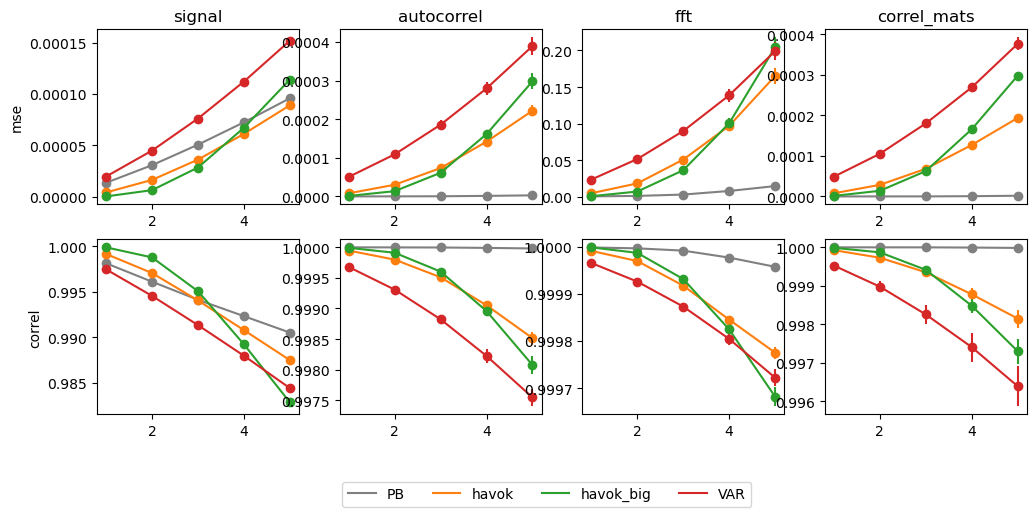

In [91]:
fig, axs = plt.subplots(len(metrics), len(stats), figsize=(12, 5))

start_ind = 0
end_ind = 5

for i, metric in enumerate(metrics):
    for j, stat in enumerate(stats):
        ax = axs[i][j]
        for model in models:
            if model != 'true' and model != 'VAR_small':
                filter_vals = ~np.isnan(curves[model][stat][metric]['mean'])
                filter_vals[np.logical_and(np.arange(len(filter_vals)) >= start_ind, np.arange(len(filter_vals)) >= end_ind)] = False
                ax.errorbar(np.array(reseeds)[filter_vals], curves[model][stat][metric]['mean'][filter_vals], yerr=curves[model][stat][metric]['se'][filter_vals], color=model_colors[model], marker='o')
#                 ax.scatter(reseeds, curves[model][stat][metric]['mean'], linestyle='-', yerr=curves[model][stat][metric]['se'])
        
#         ax.set_xscale('log')
        
        if i == 0:
            ax.set_title(stat)
        if j == 0:
            ax.set_ylabel(metric)
lns = []
for model in models:
    if model != 'true' and model != 'VAR_small':
        lns += plt.plot([], label=model, c=model_colors[model])
        labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=4)
plt.show()

In [152]:
reseed = 1

In [159]:
((results[reseed]['true']['signal'][430:580, 0] - results[reseed]['havok']['signal'][430:580, 0])**2).mean()

8.206163307575608e-07

In [158]:
((results[reseed]['true']['signal'][430:580, 0] - results[reseed]['PB']['signal'][430:580, 0])**2).mean()

8.247486279500547e-07

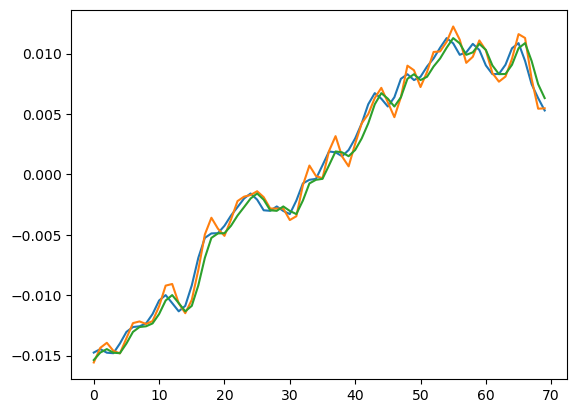

In [153]:
plt.plot(results[reseed]['true']['signal'][430:500, 0])
plt.plot(results[reseed]['havok']['signal'][430:500, 0])
plt.plot(results[reseed]['PB']['signal'][430:500, 0])

In [122]:
signal_test = load_window_from_chunks(t*dt + window*dt, t*dt + window*dt + 15000*dt, directory, unit_indices)

In [123]:
reseed = 5

In [132]:
pred2 = delase_big.predict_havok_dmd(signal_test, reseed=reseed, tail_bite=True)

In [133]:
metric_vals[10]['PB']['signal']

{'mse': array([0.00000000e+00, 7.73070608e-06, 2.63894643e-05, ...,
        5.95081999e-05, 7.37459575e-05, 8.16119394e-05]),
 'correl': array([1.        , 0.99930581, 0.99775353, ..., 0.99430114, 0.99300957,
        0.99226431])}

In [134]:
pred = np.zeros(signal_test.shape)
pred[0] = signal_test[0]
for t_ in range(1, signal_test.shape[0]):
    if t_ % reseed == 0:
        pred[t_] = signal_test[t_ - 1]
    else:
        pred[t_] = pred[t_ - 1]

In [135]:
((pred - signal_test)**2).mean()

8.961580456366477e-05

In [136]:
((pred2.cpu().numpy() - signal_test)**2).mean()

0.00011983664122608827